# Stock Market Analysis & Prediction
---

<img  style="float: left; margin-right: 10px; height: 240px" src="img/blind_monkey.jpg">

Princeton University professor Burton Malkiel claimed in his bestselling book, *A Random Walk Down Wall Street*, that 
>**"A blindfolded monkey throwing darts at a newspaper's financial pages could select a portfolio that would do just as well as one carefully selected by experts.”**

In a 2013 journal paper by Research Affiliates, [The Surprising Alpha From Malkiel's Monkey and Upside-Down Strategies](https://www.researchaffiliates.com/en_us/publications/journal-papers/p_2013_aug_surprising_alpha.html "The Surprising Alpha From Malkiel's Monkey and Upside-Down Strategies"), they replicated 100 monkeys throwing darts at the stock pages each year from 1964 to 2010. The company randomly selected 100 portfolios containing 30 stocks from a 1000 stock universe. On average, 98 out of 100 monkey portfolios beat the 1000 stock capitalization weighted stock universe each year.

Of course, there are many factors to be considered in this journal paper, but the basic premise is still very interesting. Therefore, for this project, I will compare a portfolio containing 20 random stocks to the S&P 500 over a span of 5+ years starting from 2013. The process for collecting and wrangling this data is found in the *Data_Wrangling* Jupyter notebook file. This notebook will not only look at a comparison of the performance, but also a time series analysis of both to see an in-depth comparison of an index to a portfolio of low stocks.

In [124]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace import sarimax
from pyramid.arima import auto_arima

sns.set_style("whitegrid")

In [109]:
# Import DataFrame
df = pd.read_csv('data/StockPrices.csv', parse_dates=['date'], index_col='date')
df.head()

,S&P500,Portfolio
date,,
2013-01-02,1462.42,456.7800
2013-01-03,1459.37,454.6620
2013-01-04,1466.47,456.3980
2013-01-07,1461.89,459.8856
2013-01-08,1457.15,456.0179


In [34]:
def plot_stock_df(df, title):
    """Plots dataframe for stocks."""
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title(title, fontsize=20)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price($)', fontsize=14)
    plt.legend(df.columns)
    plt.show()

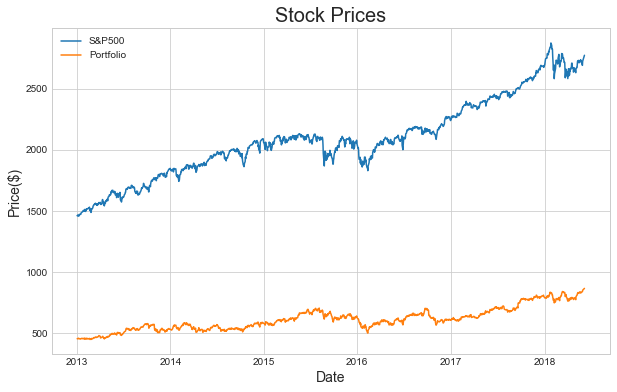

In [35]:
# Plot dataframe
plot_stock_df(df, 'Stock Prices')

It is difficult to tell which is more successful in producing money without normalizing the graph for a better comparison.

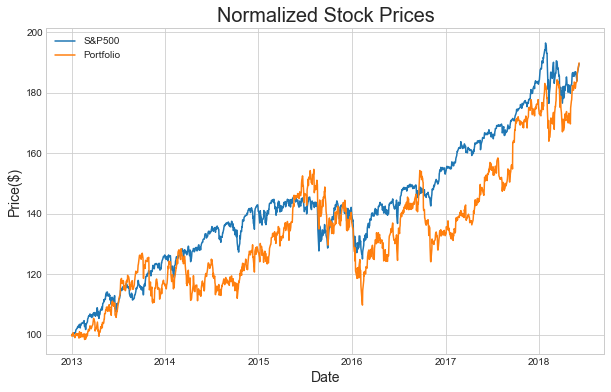

In [40]:
# Plot normalized stock prices dataframe to start at $100
df_norm = df/df.iloc[0]*100
plot_stock_df(df_norm, 'Normalized Stock Prices')

In [37]:
df_norm.describe()

,S&P500,Portfolio
count,1363.000000,1363.000000
mean,142.723241,134.376097
std,21.926793,20.392264
min,99.639638,98.456193
25%,128.357449,118.661610
50%,141.343116,132.372652
75%,155.764079,145.392640
max,196.446308,189.859451


#### Which one makes more money?

Judging from the normalized stock prices graph, it is evident that investing in the S&P500 would have yielded a safer and higher return on investment compared to the portfolio. If held for the long term, more times than not, the index outperforms the portfolio. In addition, the portfolio displays more volatility compared to the smoother index growth. Hypothetically, one can make more money investing in the portfolio if the investor gets fortunate in timing when to enter and exit. However, the index is a safer bet with better returns in this case.

To further compare the performances of each, let's assess the risk and volatility aspects of the index versus the stocks portfolio.

## Risk & Volatility
---

<img  style="float: left; margin-right: 10px; height: 240px"src="img/risk.jpg">

To look at the risk and volatility comparison of the S&P 500 and the Portfolio, I will analyze the time series for trend and autocorrelation. From the previous graphs, it is apparent that each line has a trend upwards. However, using moving averages, the trend line should demonstrate how it looks for holding a specified longer term without the noise of the peaks and troughs seen in the original line graphs. 

In addition, autocorrelation looks at the correlation of the times series to a lagged version of itself. Thus, it can assess the stability of the prices as it looks at longer time frames. A high autocorrelation would indicate the stock prices are stable in its historical movements and little movement from the trend line is shown. In a sense, it shows how safe a bet it is long-term for the particular time series. 

### Trend

In [49]:
def plot_ax_moving_average(y, ax, window):
    """Plots y data in axes and date window for rolling mean."""
    ax.plot(y.index, y, label='Original')
    ax.plot(y.index, y.rolling(window=window).mean(), label='{} Days Rolling Mean'.format(window), color='crimson')
    ax.plot(y.index, y.rolling(window=window).std(), color='darkslateblue', label='Moving average standard deviation')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price($)")
    ax.set_title("{} Days Moving Average".format(window))
    ax.legend(loc=2)
    return

In [50]:
def plot_full_moving_average(y, title):
    """Plots 2x2 subplots for y data moving averages in month time frames."""
    # define figure and axes
    fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
    fig.set_figwidth(12)
    fig.set_figheight(8)
    #upper left
    plot_ax_moving_average(y, axes[0][0], 30)
    # upper right
    plot_ax_moving_average(y, axes[0][1], 60)
    # lower left
    plot_ax_moving_average(y, axes[1][0], 90)
    # lower right
    plot_ax_moving_average(y, axes[1][1], 120)
    
    plt.tight_layout()
    fig.suptitle(title, fontsize=18)
    fig.subplots_adjust(top=0.92)
    plt.show()
    return

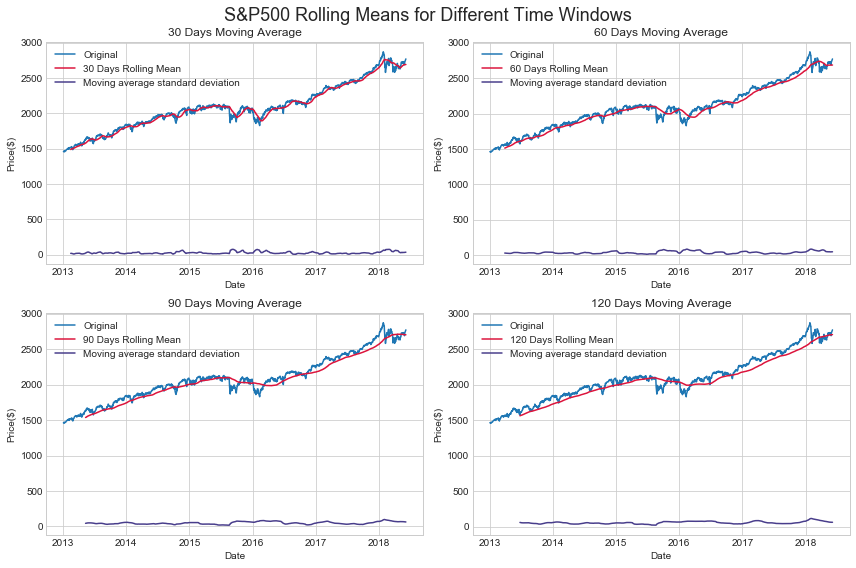

In [51]:
# Plot moving average for S&P500 for different time windows
plot_full_moving_average(df['S&P500'], 'S&P500 Rolling Means for Different Time Windows')

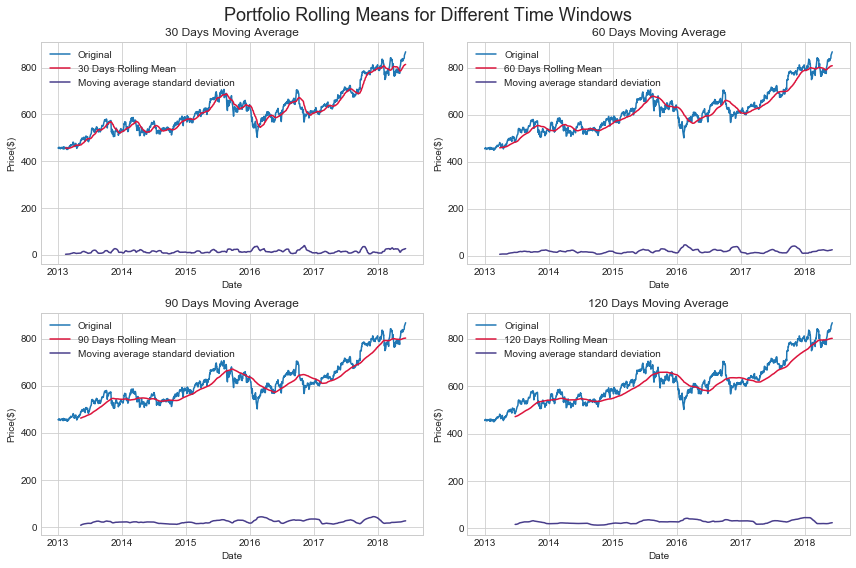

In [52]:
# Plot moving average for Portfolio for different time windows
plot_full_moving_average(df['Portfolio'], 'Portfolio Rolling Means for Different Time Windows')

#### Peaks and Troughs in Trend

<img  style="float: left; margin-right: 10px; height: 180px"src="img/peaks_valleys.png">

From the rolling mean plots, it can be judged that there is a positive trend in both the S&P500 and Portfolio data. With more days in the rolling mean window, the lines for each smooths out to reveal its long-term investment potential. The S&P 500 graphs smooth out very quickly where from 90 days and on the graph becomes an almost positive linear trend with a plateau or minor dip at 2016. On the contrary, the Portfolio has peaks and valleys still present in the 120 days moving average graph with erratic movements and price dips in 2015, mid 2016, and early 2017. In addition, the standard deviation lines display higher values compared to the S&P 500 lines revealing the movements are of higher range from the mean. As a long term investor, this kind of movement would be unsettling.

### Autocorrelation

In [39]:
def plot_scatter_time_lag(data, title):
    """Plots 3x3 subplots of time lagged scatter plots of input data."""
    
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
 
    for ax, lag in zip(axes.flat, [15,30,45,60,75,90,120,150,180]):
        lag_str = '{} days'.format(lag)
        X = (pd.concat([data, data.shift(-lag)], axis=1, keys=['y']+[lag_str]).dropna())

        # plot data
        X.plot(ax=ax, kind='scatter', y='y', x=lag_str)
        corr = X.corr().as_matrix()[0][1]
        ax.set_ylabel('Original')
        ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr))
        ax.set_aspect('equal')

        # top and right spine from plot
        sns.despine()
        
    fig.suptitle(title, fontsize=18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    plt.show()
    return

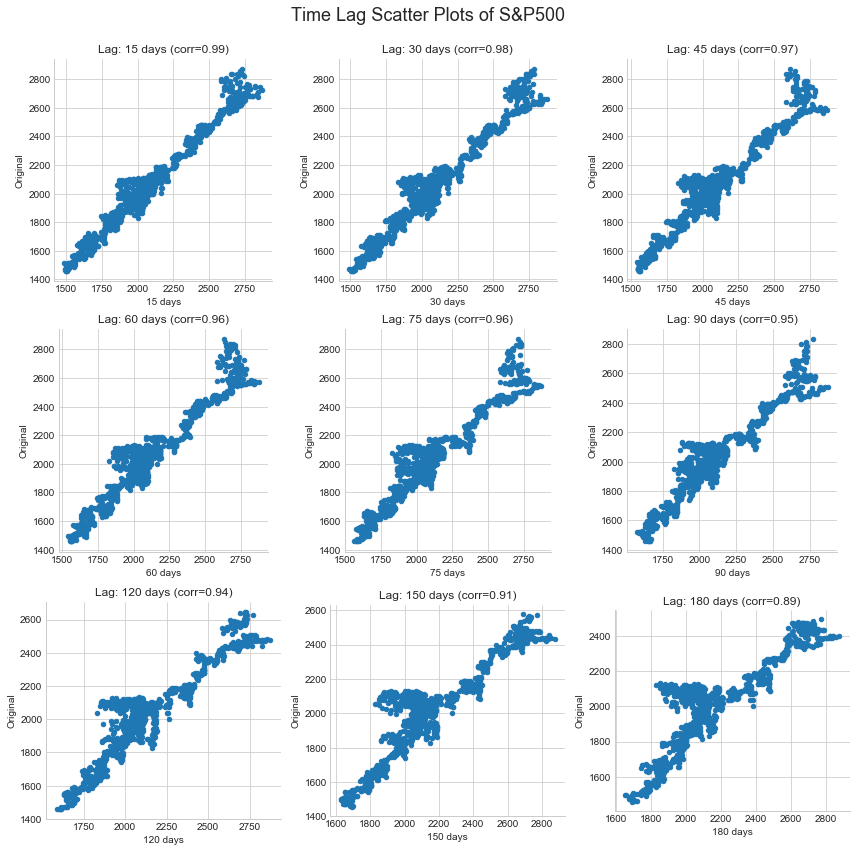

In [40]:
plot_scatter_time_lag(df['S&P500'], 'Time Lag Scatter Plots of S&P500')

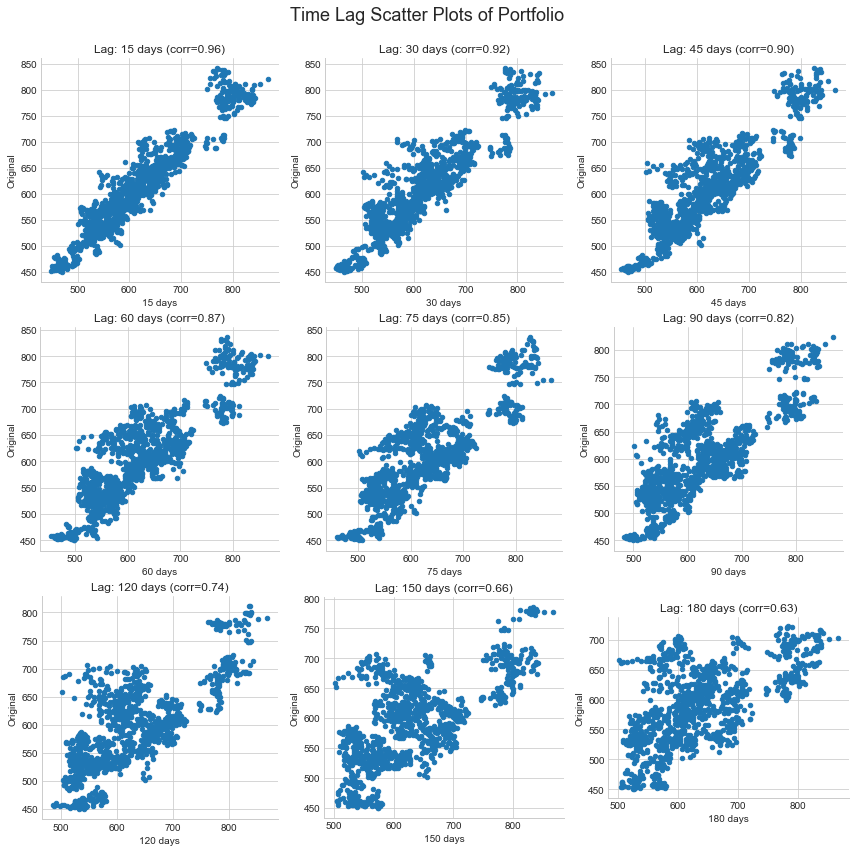

In [41]:
plot_scatter_time_lag(df['Portfolio'], 'Time Lag Scatter Plots of Portfolio')

#### Present values vs the Past values

For S&P 500, the correlation value stays relatively high even with increasing time lags. It holds 0.89 correlation even at 180 days. For the Portfolio, the correlation degrades quite quickly from 0.9 range to 0.6 range over increasing lag. This indicates that the historical values are not as indicative to the present values of the portfolio data. Again, this supports the idea how an investor would experience the volatility compared to the more stable S&P 500 index.

## Prediction of the Future
---

<img  style="float: left; margin-right: 10px; height: 290px" src="img/past_sign.jpg">

Now that I have looked at the present and past values, how does the S&P 500 and Portfolio compare in their projected future values?

In order to proceed with predictive modeling for future values, I have to establish the time series are in some form stationary.  A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary through mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past.

With a stationary time series, I am able to obtain meaningful means, variances, and correlations with other variables. Such statistics are useful as descriptors of future behavior only if the series is stationary. For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. Also, if the mean and variance of a series are not well-defined, then neither are its correlations with other variables.

### Testing Stationarity

In [50]:
def ts_plot(y, lags=None, title=''):
    """Calculate acf, pacf, histogram, and qq plot for a given time series"""
    
    # if time series is not a Series object, make it so
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # initialize figure and axes
    fig = plt.figure(figsize=(12, 10))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    plt.legend(loc='best')
    ts_ax.set_title(title);
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Normal QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plt.tight_layout()
    plt.show()
    return

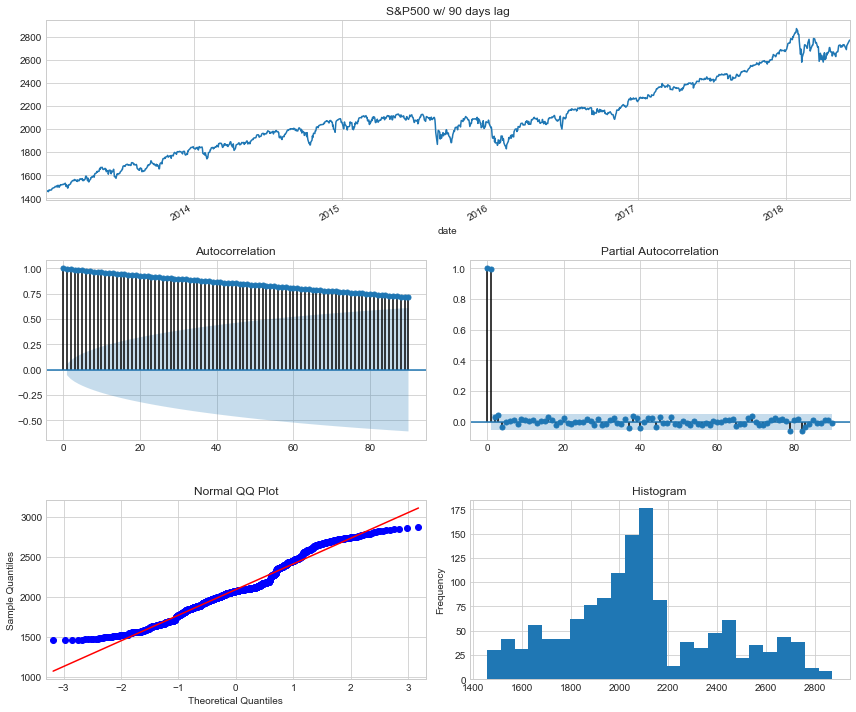

In [51]:
# Plot S&P 500 with 90 days lag
ts_plot(df['S&P500'], lags=90, title='S&P500 w/ 90 days lag')

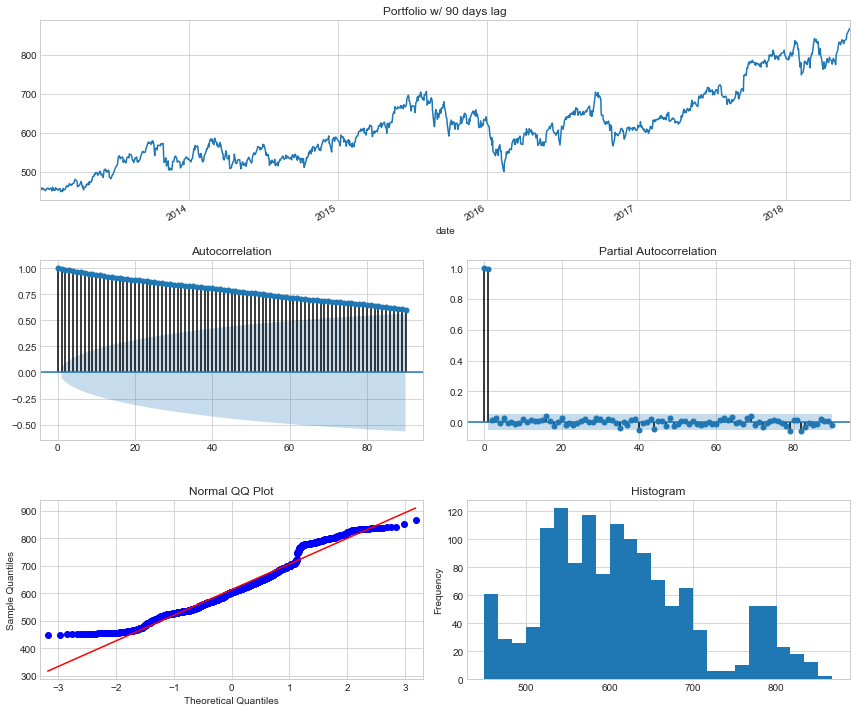

In [52]:
# Plot Portfolio with 90 days lag
ts_plot(df['Portfolio'], lags=90, title='Portfolio w/ 90 days lag')

#### Random Walk Process
Analyzing the S&P500 and Portfolio plots, they exhibit traits of a random walk process, which is non-stationary. This is characterized by high ACF for any lag length and a high PACF for the first lag only. The normal QQ plot and the histogram indicate that the series is not stationary. A stationary process like white noise would exhibit fitted data to the QQ plot line and normal distribution in the histogram.

### Noise

The original time series are not stationary due to some factors and some form of transformation will be needed to stationarize them. Using seasonal decomposition, the time series will be stripped away of any possible trend and seasonal effects to reveal a residual, which should help in making a decision on transformation methods.

In [7]:
def plot_season_decomp(data, title, model='multiplicative'):
    """Plots seasonal decomposition of data."""
    decomp = seasonal_decompose(data, freq=90, model=model)
    decomp.plot()
    plt.suptitle(title)
    plt.show()

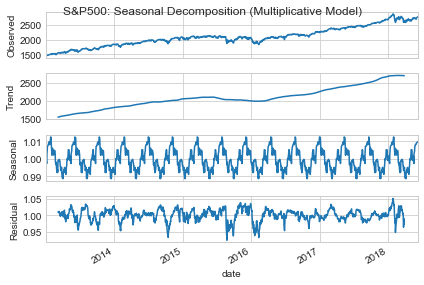

In [8]:
# Plot seasonal decomposition of S&P500 with Multiplicative model
plot_season_decomp(df['S&P500'], 'S&P500: Seasonal Decomposition (Multiplicative Model)')

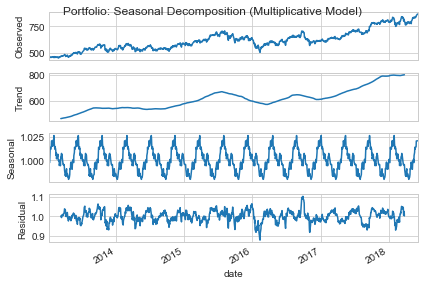

In [9]:
# Plot seasonal decomposition of Portfolio with Multiplicative model
plot_season_decomp(df['Portfolio'], 'Portfolio: Seasonal Decomposition (Multiplicative Model)')

> The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate. With economic time series, multiplicative models are more common. So, for both data sets, the multiplicative models are applied.

#### Results of Seasonal Decomposition

The seasonal decompositions of the two time series reveal the residuals look like white noise, which is stationary. This will need to be tested thoroughly, but judging from the visuals, it seems removing the trend will stationarize the time series. Also both time series exhibit seasonal patterns in the graphs, which also needs to be explored further for predictive modeling.

### Seasonality

In [80]:
def plot_seasonal_effect_months(data, value):
    """Takes in dataframe for deep copy. Pivots df to plot seasonal effects per month."""
    df = data.copy()
    df['Date'] = df.index
    df = df.resample('M', on='Date').sum()
    df['Month'] = df.index.strftime('%b')
    df['Year'] = df.index.year

    # create nice axes names
    month_names = pd.date_range(start='2013-01-01', periods=12, freq='MS').strftime('%b')
    
    # reshape data using 'Year' as index and 'Month' as column
    df_piv_line = df.pivot(index='Month', columns='Year', values=value)
    df_piv_line = df_piv_line.reindex(index=month_names)
    
    # excluding jun 2018 data since lacking whole month data points.
    df_piv_line.loc['Jun', 2018] = np.nan
    
    # create line plot
    df_piv_line.plot(colormap='jet', figsize=(10,5))
    plt.title('{}: Seasonal Effect per Month'.format(value), fontsize=18)
    plt.ylabel('Price')
    plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
    plt.show()
    return

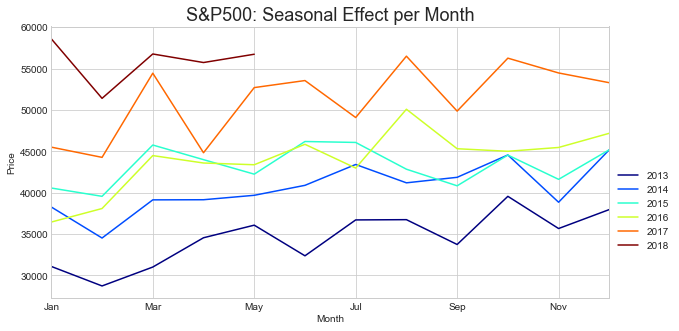

In [81]:
# Plot S&P500 Seasonal Effect per Month
plot_seasonal_effect_months(df, 'S&P500')

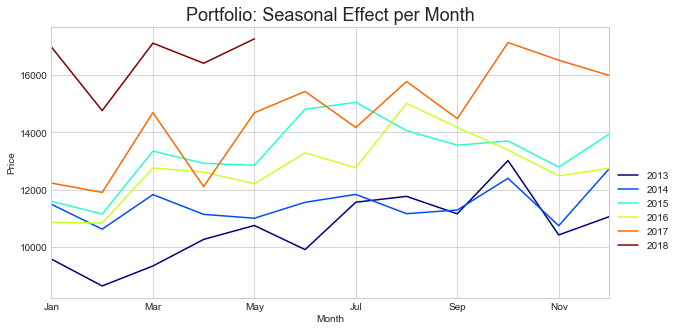

In [82]:
# Plot Portfolio Seasonal Effect per Month
plot_seasonal_effect_months(df, 'Portfolio')

In [85]:
def seasonal_box_plots(data, value):
    """Box plots for monthly data with input of dataframe and value to pivot on."""
    df = data.copy()
    df['Date'] = df.index
    df = df.resample('M', on='Date').sum()
    df['Month'] = df.index.strftime('%b')
    df['Year'] = df.index.year

    # create nice axes names
    month_names = pd.date_range(start='2013-01-01', periods=12, freq='MS').strftime('%b')

    # reshape date
    df_piv_box = df.pivot(index='Year', columns='Month', values=value)

    # reindex pivot table with 'month_names'
    df_piv_box = df_piv_box.reindex(columns=month_names)
    
    # excluding jun 2018 data since lacking whole month data points. outlier.
    df_piv_box.loc[2018,'Jun'] = np.nan
    
    # create a box plot
    fig, ax = plt.subplots()
    df_piv_box.plot(ax=ax, kind='box', figsize=(10,6))
    ax.set_title('{}: Seasonal Effect per Month'.format(value), fontsize=18)
    ax.set_xlabel('Month')
    ax.set_ylabel('Price')
    ax.xaxis.set_ticks_position('bottom')
    fig.tight_layout()
    plt.show()

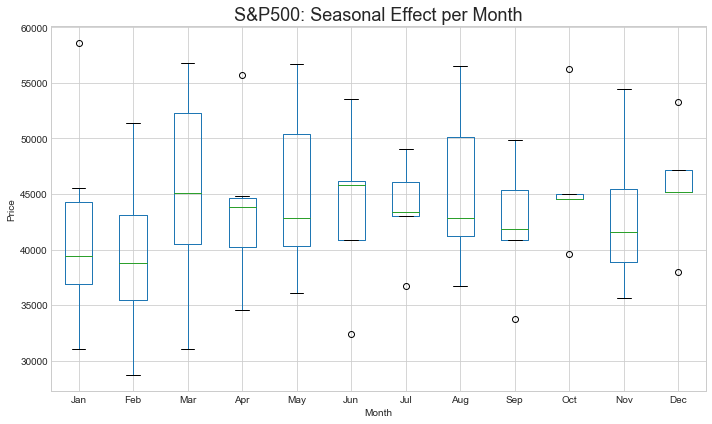

In [86]:
# S&P500 seasonal effects shown in monthly box plots
seasonal_box_plots(df, 'S&P500')

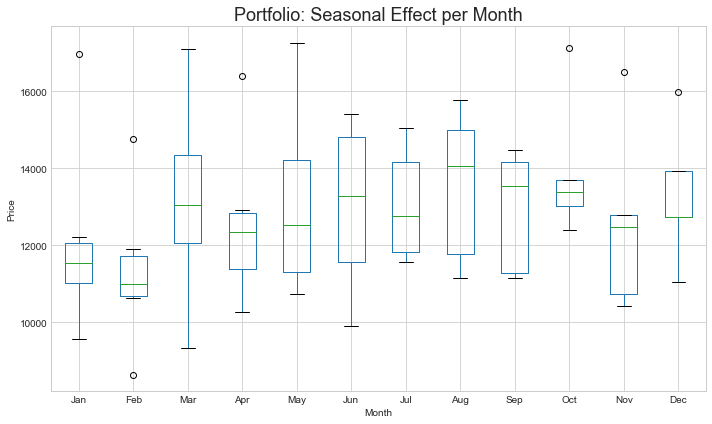

In [87]:
# Portfolio seasonal effects shown in monthly box plots
seasonal_box_plots(df, 'Portfolio')

#### Quarterly Seasons in the Stock Market

<img  style="float: right; margin-left: 10px; height: 200px" src="img/bull_bear.jpg">

Intuitively, it would make sense that there are seasonal trends aligning with the earning seasons of publicly traded companies when they release their quarterly earning reports. In general, each earnings season begins one or two weeks after the last month of each quarter (December, March, June, and September). The plots seem to confirm this intuition.

Judging from the line plots of different years, there are seasonal effects aligning with the quarterly months. Looking at the boxplots, it is more evident that there is a pattern of high movement in the months before the quarterly earning reports for the S&P500. This is not as apparent in the Portfolio boxplots, which could be explained by the fact that it encompasses low volume and lower price stocks adding to more volatility.

## Augmented Dickey-Fuller Test
---

The Augmented Dickey-Fuller test will test if the time series and any transformation of it is stationary or not.

* **H<sub>0</sub>**: Unit root is present in the time series and thus is non-stationary.
* **H<sub>1</sub>**: The time series is stationary.
* **α**: 0.05 

In [299]:
def adf_test(y):
    # perform Augmented Dickey Fuller test
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [300]:
# Augmented Dickey Fuller Test for S&P500 data
adf_test(df['S&P500'])

Results of Augmented Dickey-Fuller test:
test statistic            -0.711519
p-value                    0.843743
# of lags                  3.000000
# of observations       1359.000000
Critical Value (1%)       -3.435171
Critical Value (5%)       -2.863669
Critical Value (10%)      -2.567904
dtype: float64


In [301]:
# Augmented Dickey Fuller Test for Portfolio data
adf_test(df['Portfolio'])

Results of Augmented Dickey-Fuller test:
test statistic            -0.724602
p-value                    0.840274
# of lags                  0.000000
# of observations       1362.000000
Critical Value (1%)       -3.435160
Critical Value (5%)       -2.863664
Critical Value (10%)      -2.567901
dtype: float64


> For both the index and the portfolio:
* p-value is larger than 0.05 
* test statistic is larger than the critical value (5%)
* The null hypothesis cannot be rejected and thus the series is not stationary.

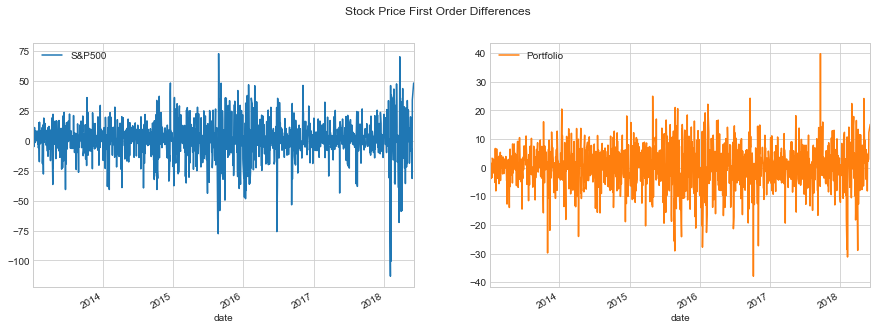

In [46]:
# Plot dataframe of first order differences
df_diff = df.diff().dropna()
df_diff.plot(subplots=True, title='Stock Price First Order Differences', layout=(1,2), figsize=(15,5))
plt.show()

> First order differences plots look like white noise or stationary.

In [302]:
# Augmented Dickey Fuller Test for S&P500 first order difference
adf_test(df_diff['S&P500'])

Results of Augmented Dickey-Fuller test:
test statistic           -21.397940
p-value                    0.000000
# of lags                  2.000000
# of observations       1359.000000
Critical Value (1%)       -3.435171
Critical Value (5%)       -2.863669
Critical Value (10%)      -2.567904
dtype: float64


In [303]:
# Augmented Dickey Fuller Test for Portfolio first order difference
adf_test(df_diff['Portfolio'])

Results of Augmented Dickey-Fuller test:
test statistic           -19.445322
p-value                    0.000000
# of lags                  3.000000
# of observations       1358.000000
Critical Value (1%)       -3.435175
Critical Value (5%)       -2.863671
Critical Value (10%)      -2.567904
dtype: float64


>The first order difference data: 
* p-values of 0.00
* test statistic values way below 0.01 critical value
* null hypothesis can be rejected and thus both the index and portfolio data are stationary.

## Predictive Modeling

Since I have stationarized the time series, I can proceed to predictive modeling. Since there is a seasonal component to the data, it makes sense to use seasonal ARIMA. To find the best parameters for the model, I will measure the AIC score and decide the p, d, q values corresponding to the AR, difference, and MA orders respectively.

#### Finding the best ARIMA and seasonal order values

In [142]:
def stepwise_best_model(data):    
    # Stepwise model set up with 1st order difference, seasonality, and quarterly seasons
    stepwise_model = auto_arima(df[data], start_p=1, start_q=1,
                               max_p=3, max_q=3, m=4,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    
    # Best model determined from testing order values with AIC values  
    print('{} Best Model'.format(data))
    print(stepwise_model)
    print('AIC: {:.4f}'.format(stepwise_model.aic()))

In [143]:
# Best model for S&P500
stepwise_best_model('S&P500')

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 4); AIC=11483.372, BIC=11509.459, Fit time=2.344 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 4); AIC=12064.530, BIC=12085.400, Fit time=0.803 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 4); AIC=11484.391, BIC=11505.261, Fit time=0.933 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 4); AIC=11484.921, BIC=11516.225, Fit time=2.761 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 4); AIC=12242.505, BIC=12263.375, Fit time=1.631 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 4); AIC=11486.092, BIC=11517.396, Fit time=3.786 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 4); AIC=11487.338, BIC=11523.861, Fit time=4.490 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1

In [118]:
# Best model for Portfolio
stepwise_best_model('Portfolio')

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 4); AIC=9365.848, BIC=9391.935, Fit time=1.926 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 4); AIC=9924.793, BIC=9945.662, Fit time=0.809 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 4); AIC=9366.562, BIC=9387.432, Fit time=1.753 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 4); AIC=9363.793, BIC=9395.098, Fit time=1.924 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 4); AIC=9807.694, BIC=9833.781, Fit time=1.856 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 4); AIC=9366.132, BIC=9402.654, Fit time=4.831 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 4); AIC=10179.911, BIC=10200.781, Fit time=1.825 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 4); AIC=9367.545, BIC=9409.285, Fit time=5.053 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1

> The best model orders are:
* S&P 500: order = (2,1,2), seasonal_order = (0,1,1,4)
* Portfolio: order = (0,1,0), seasonal_order = (1,1,1,4)

#### Seasonal ARIMA with Best Order Values

In [147]:
# Copying dataframe with business days frequency for SARIMAX modeling
df_bfreq = df.copy().asfreq('B')

In [148]:
def sarimax_model(data, order, seasonal_order):
    # Define SARIMAX model and fit it to the data
    mdl = sm.tsa.statespace.SARIMAX(df_bfreq[data],
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
    res = mdl.fit(maxiter=200)
    return res

In [149]:
# Fit model for sarimax of S&P500 and Portfolio
sp500_sarimax = sarimax_model('S&P500', (2,1,2), (0,1,1,4))
portfolio_sarimax = sarimax_model('Portfolio', (0,1,0), (1,1,1,4))

#### Plotting Fitted Values & One-Step Ahead Predictions

In [164]:
def plot_sarimax(data, model, start, end, title, dynamic=False):   
    
    # Set start and end date
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    # one-step ahead prediction and confidence bounds
    pred = model.get_prediction(start=start_date, end=end_date,
                              dynamic=dynamic, full_results=True)
    pred_ci = pred.conf_int()

    # plot one-step ahead prediction
    ax = df_bfreq[data]['2017-06-06':].plot(label='Observed',figsize=(16, 8),color='#006699')
    model.fittedvalues['2017-06-06':].plot(ax=ax, label='Fitted Values', alpha=.7, color='green')
    pred.predicted_mean.plot(ax=ax, label='Forecasted to Observed', alpha=.7, color='#ff0066')

    # draw confidence bound (gray)
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='#ff0066', alpha=.25)
    
    # style the plot
    ax.fill_betweenx(ax.get_ylim(), start_date, df_bfreq[data].index[-1], alpha=.15, zorder=-1, color='grey')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
     
    # Calculate mse and rmse for prediction
    y_hat = pred.predicted_mean
    y_true = df_bfreq[data][start:]

    # compute the mean square error
    mse = ((y_hat - y_true) ** 2).mean()
    print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

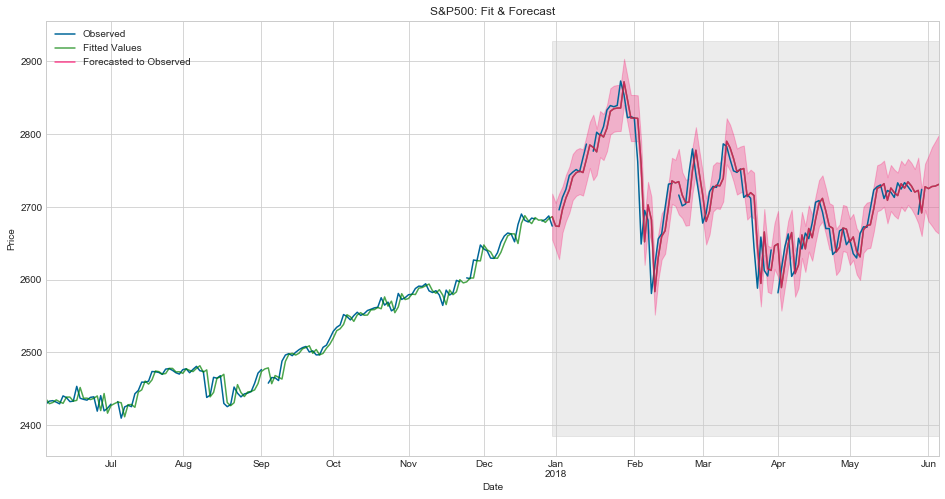

Prediction quality: 866.12 MSE (29.43 RMSE)


In [165]:
# Plotting model for S&P500 with one step ahead prediction
plot_sarimax('S&P500', sp500_sarimax, '2017-12-29', '2018-06-06', 'S&P500: Fit & Forecast')

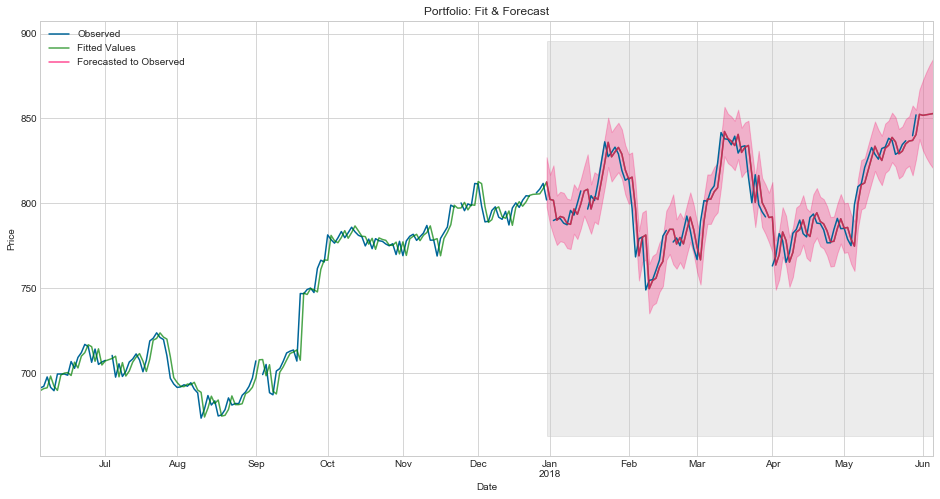

Prediction quality: 97.32 MSE (9.87 RMSE)


In [166]:
# Plotting model for Portfolio with one step ahead prediction
plot_sarimax('Portfolio', portfolio_sarimax, '2017-12-29', '2018-06-06', 'Portfolio: Fit & Forecast')

> Each plot visualizes how well the models perform to the data. The forecasted period is from the beginning of 2018 to June 2018 and compares to the observed. It is important to note that the forecasting is a one-step ahead predictive modeling, so it is aware of the data as it moves along comparative to the future forecasting done in this report. The pink shaded area along the forecasted line is the confidence interval to the forecast. The prediction error values for S&P 500 and Portfolio are 866.12 MSE (29.43 RMSE) and 97.32 MSE (9.87 RMSE), respectively.

#### Future Forecast of 90 Days

In [170]:
def future_forecast_plot(data, model):     
    # get forecast 90 steps ahead in future
    pred_uc = model.get_forecast(steps=90)

    # get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()

    # plot time series and long-term forecast
    ax = df_bfreq[data]['2016-06-06':].plot(label='Observed', figsize=(16, 8), color='#006699')
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066')
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='#ff0066', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend(loc='upper left')
    plt.title('{}: Future Forecast 90 Days'.format(data))
    plt.show()

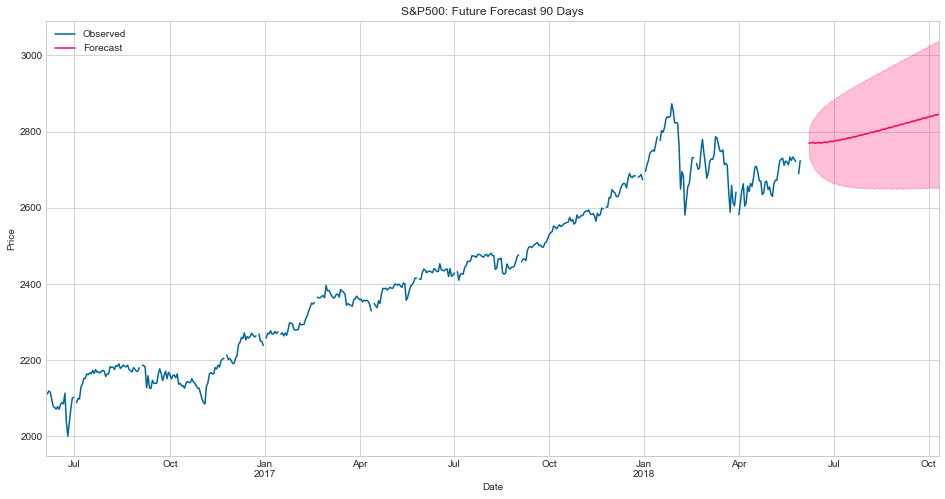

In [171]:
# Future 90 days forecast for S&P 500
future_forecast_plot('S&P500', sp500_sarimax)

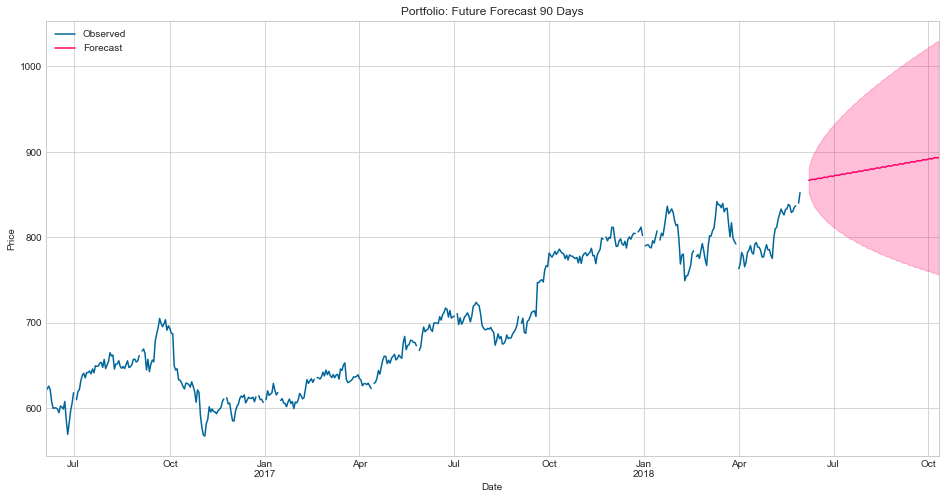

In [172]:
# Future 90 days forecast for Portfolio
future_forecast_plot('Portfolio', portfolio_sarimax)

> The future forecasts 90 days beyond the data. Interesting to note is the band difference with the portfolio's confidence band spreading much more compared to the S&P 500. This could be attributed to the volatility of the historical data of the portfolio compared to the index. The forecasts are presented as relatively flat lines. Arguably, any forecast that isn't flat would be the non-meaningful one, because it would have to be making some strong implicit assumptions in order to project such details into the future.

### Beyond this Project
---

<img  style="float: right; margin-left: 10px; height: 200px" src="img/beyond.jpg">

As one can imagine, predicting the stock market with a pure ARIMA modeling is insufficient. Although there may be some merit in looking at historical data, the stocks of companies are impacted by many variables beyond the data such as a company CEO becoming embroiled in a scandal or cultural shifts in society that impacts certain industries trends. 

I can imagine improving this model to encompass several different methods to optimize prediction of the stock market. In addition to ARIMA modeling, one can implement neural networks such as RNN. Also, NLP use for finance articles, social media feeds, quarterly earnings reports, and more can help in implementing a more robust and effective ensemble modeling method on top of time series modeling.